In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import IsolationForest, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           precision_recall_curve, auc, roc_curve, average_precision_score,
                           precision_score, recall_score, f1_score)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import scipy.stats as stats
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# ==============================================================
# 1. LOAD AND EXPLORE DATA
# ==============================================================
print(" LOADING AND EXPLORING DATA")
print("="*50)
df = pd.read_csv('/content/bs140513_032310.csv')
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())
print("\nFraud Distribution:")
fraud_counts = df['fraud'].value_counts()
print(fraud_counts)
print(f"Fraud Rate: {df['fraud'].mean():.4f} ({df['fraud'].mean()*100:.2f}%)")

 LOADING AND EXPLORING DATA
Dataset Shape: (594643, 10)

First 5 rows:
   step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'    4.55      0  
1  'es_transportation'   39.68      0  
2  'es_transportation'   26.89      0  
3  'es_transportation'   17.25      0  
4  'es_transportation'   35.72      0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         59


 EXPLORATORY DATA ANALYSIS


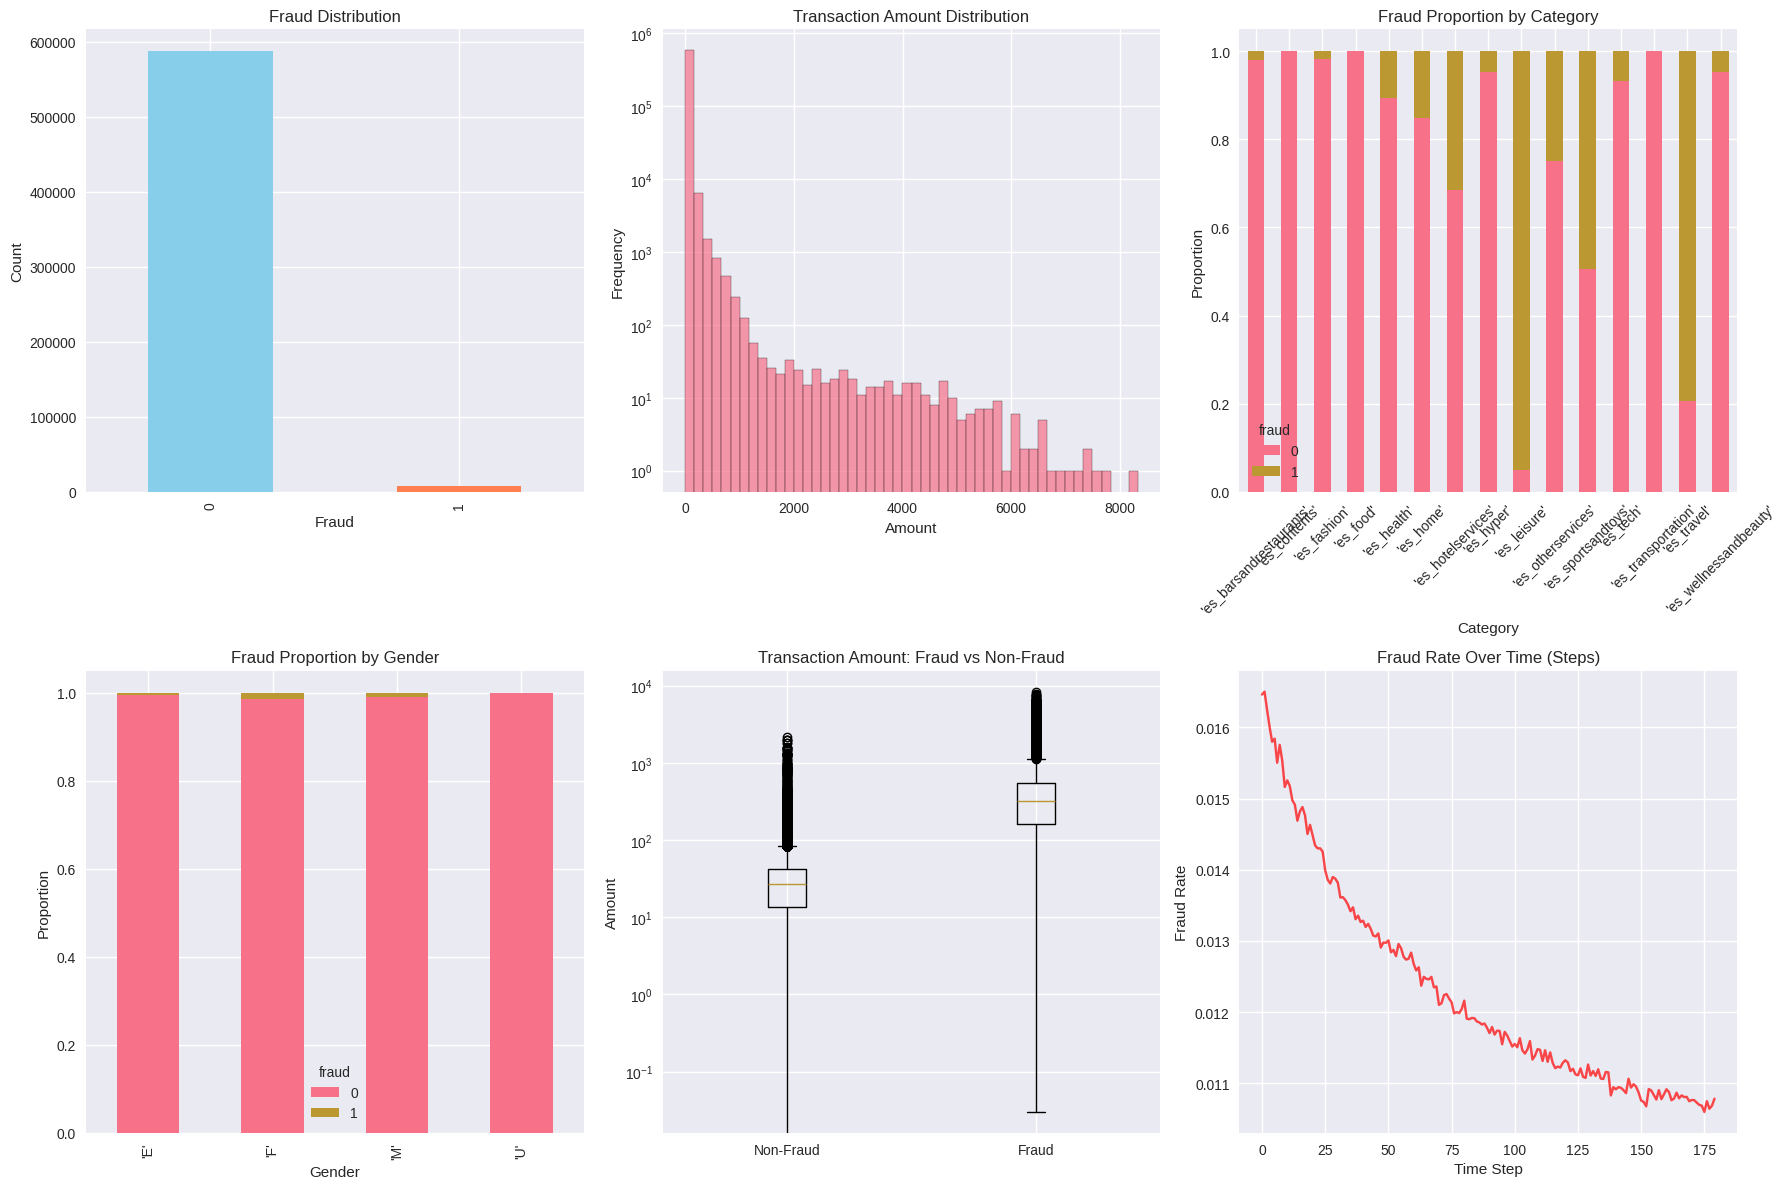

In [4]:
# ==============================================================
# 2. COMPREHENSIVE EDA VISUALIZATIONS
# ==============================================================
print("\n EXPLORATORY DATA ANALYSIS")
print("="*60)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Fraud distribution
fraud_counts.plot(kind='bar', ax=axes[0,0], color=['skyblue', 'coral'])
axes[0,0].set_title('Fraud Distribution')
axes[0,0].set_xlabel('Fraud')
axes[0,0].set_ylabel('Count')

# 2. Transaction amount distribution (log scale)
axes[0,1].hist(df['amount'], bins=50, edgecolor='black', alpha=0.7)
axes[0,1].set_title('Transaction Amount Distribution')
axes[0,1].set_xlabel('Amount')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_yscale('log')

# 3. Fraud by category
fraud_by_category = pd.crosstab(df['category'], df['fraud'], normalize='index')
fraud_by_category.plot(kind='bar', ax=axes[0,2], stacked=True)
axes[0,2].set_title('Fraud Proportion by Category')
axes[0,2].set_xlabel('Category')
axes[0,2].set_ylabel('Proportion')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Fraud by gender
fraud_by_gender = pd.crosstab(df['gender'], df['fraud'], normalize='index')
fraud_by_gender.plot(kind='bar', ax=axes[1,0], stacked=True)
axes[1,0].set_title('Fraud Proportion by Gender')
axes[1,0].set_xlabel('Gender')
axes[1,0].set_ylabel('Proportion')

# 5. Amount vs Fraud (boxplot)
fraud_data = df[df['fraud'] == 1]['amount']
non_fraud_data = df[df['fraud'] == 0]['amount']
axes[1,1].boxplot([non_fraud_data, fraud_data], labels=['Non-Fraud', 'Fraud'])
axes[1,1].set_title('Transaction Amount: Fraud vs Non-Fraud')
axes[1,1].set_ylabel('Amount')
axes[1,1].set_yscale('log')

# 6. Time step analysis
fraud_over_time = df.groupby('step')['fraud'].mean()
axes[1,2].plot(fraud_over_time.index, fraud_over_time.values, color='red', alpha=0.7)
axes[1,2].set_title('Fraud Rate Over Time (Steps)')
axes[1,2].set_xlabel('Time Step')
axes[1,2].set_ylabel('Fraud Rate')

plt.tight_layout()
plt.show()

In [5]:
# ==============================================================
# 3. ADVANCED DATA PREPROCESSING
# ==============================================================
print("\n DATA PREPROCESSING")
print("="*50)
# 3.1 Remove quotes and clean data
cols_with_quotes = ['customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category']
for col in cols_with_quotes:
    df[col] = df[col].astype(str).str.replace("'", "")
# 3.2 Convert data types
df['age'] = pd.to_numeric(df['age'], errors='coerce').fillna(-1).astype(int)
df['amount'] = df['amount'].astype(float)
df['step'] = df['step'].astype(int)
df['fraud'] = df['fraud'].astype(int)

# Map 'E' to 'F' and 'U' to 'M' to reduce gender categories to only M and F
df['gender'] = df['gender'].replace({'E': 'F', 'U': 'M'})

# 3.3 Feature Engineering
print("Creating advanced features...")
# Transaction frequency features
customer_freq = df.groupby('customer').size().to_dict()
merchant_freq = df.groupby('merchant').size().to_dict()
category_freq = df.groupby('category').size().to_dict()
df['customer_freq'] = df['customer'].map(customer_freq)
df['merchant_freq'] = df['merchant'].map(merchant_freq)
df['category_freq'] = df['category'].map(category_freq)
# Fraud history features (using expanding window)
df = df.sort_values(['customer', 'step'])
df['customer_fraud_history'] = df.groupby('customer')['fraud'].expanding().mean().reset_index(level=0, drop=True)
df['customer_fraud_history'] = df['customer_fraud_history'].fillna(0)
# Amount statistics per customer
customer_amount_stats = df.groupby('customer')['amount'].agg(['mean', 'std', 'max']).reset_index()
customer_amount_stats.columns = ['customer', 'cust_avg_amount', 'cust_std_amount', 'cust_max_amount']
df = df.merge(customer_amount_stats, on='customer', how='left')
# Time-based features
df['hour_of_day'] = df['step'] % 24
df['day_of_week'] = (df['step'] // 24) % 7
# 3.4 Filter rare customers/merchants
min_freq = 5
cust_counts = df['customer'].value_counts()
merch_counts = df['merchant'].value_counts()
df = df[
    df['customer'].isin(cust_counts[cust_counts >= min_freq].index) &
    df['merchant'].isin(merch_counts[merch_counts >= min_freq].index)
]
print(f"After frequency filter: {df.shape}")
# 3.5 Encode categorical variables with frequency encoding
print("Encoding categorical variables...")
# Frequency encoding for high cardinality features
df['customer_encoded'] = df['customer'].map(customer_freq)
df['merchant_encoded'] = df['merchant'].map(merchant_freq)
# Label encoding for category and gender
le_category = LabelEncoder()
le_gender = LabelEncoder()
df['category_encoded'] = le_category.fit_transform(df['category'])
df['gender_encoded'] = le_gender.fit_transform(df['gender'])
# 3.6 Select final features
feature_columns = [
    'step', 'amount', 'age',
    'customer_encoded', 'merchant_encoded', 'category_encoded', 'gender_encoded',
    'customer_freq', 'merchant_freq', 'category_freq',
    'customer_fraud_history', 'cust_avg_amount', 'cust_std_amount', 'cust_max_amount',
    'hour_of_day', 'day_of_week'
]
X = df[feature_columns]
y = df['fraud']
print(f"Final feature set: {X.shape}")


 DATA PREPROCESSING
Creating advanced features...
After frequency filter: (594640, 19)
Encoding categorical variables...
Final feature set: (594640, 16)



 FRAUD PROPORTION BY GENDER


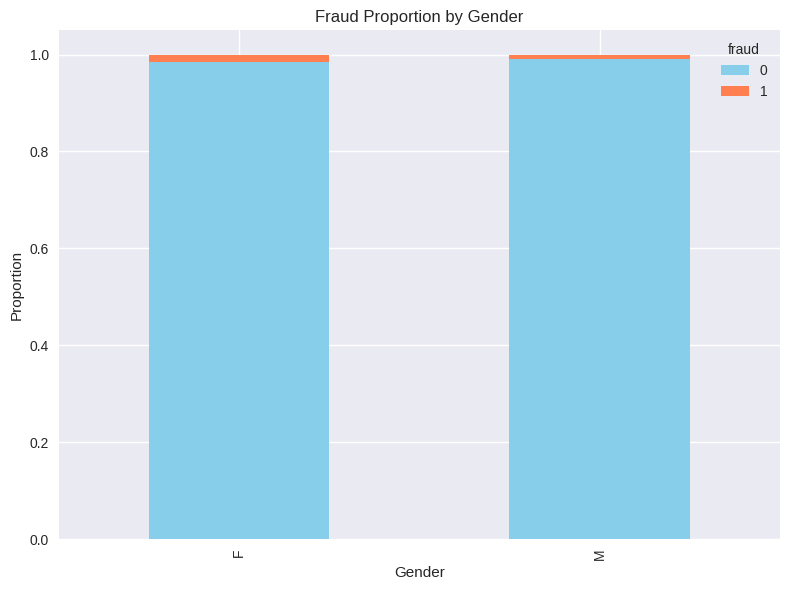

In [6]:
print("\n FRAUD PROPORTION BY GENDER")
print("=" * 60)

# Create a single figure for the gender plot
fig, ax = plt.subplots(figsize=(8, 6))

# Fraud by gender
fraud_by_gender = pd.crosstab(df['gender'], df['fraud'], normalize='index')
fraud_by_gender.plot(kind='bar', ax=ax, stacked=True, color=['skyblue', 'coral'])

# Customize the plot
ax.set_title('Fraud Proportion by Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Proportion')

plt.tight_layout()
plt.show()

In [7]:

# ==============================================================
# 4. TRAIN-VALIDATION-TEST SPLIT WITH TIME-BASED SPLITTING
# ==============================================================
print("\n DATA SPLITTING (TIME-BASED)")
print("="*60)
# Sort by time step for realistic time-series split
df_sorted = df.sort_values('step')
# Split: 60% train, 20% validation, 20% test
train_threshold = df_sorted['step'].quantile(0.6)
val_threshold = df_sorted['step'].quantile(0.8)

train_mask = df_sorted['step'] <= train_threshold
val_mask = (df_sorted['step'] > train_threshold) & (df_sorted['step'] <= val_threshold)
test_mask = df_sorted['step'] > val_threshold

X_train = X[train_mask]
y_train = y[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print(f"\nTrain set: {X_train.shape}, Fraud rate: {y_train.mean():.6f}")
print(f"Validation set: {X_val.shape}, Fraud rate: {y_val.mean():.6f}")
print(f"Test set: {X_test.shape}, Fraud rate: {y_test.mean():.6f}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


 DATA SPLITTING (TIME-BASED)

Train set: (357135, 16), Fraud rate: 0.012880
Validation set: (118867, 16), Fraud rate: 0.011105
Test set: (118638, 16), Fraud rate: 0.010789



 BALANCING TRAINING DATA (SMOTE - TRAINING SET ONLY)
 IMPORTANT: Only the training set is balanced. Validation and test sets remain UNBALANCED.
This prevents data leakage and ensures realistic model evaluation.



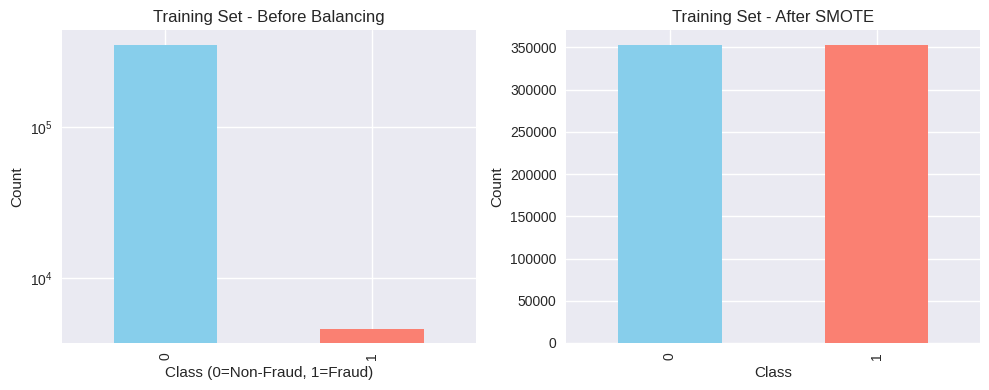

Training set (balanced) – Non-Fraud: 352,535, Fraud: 352,535
Training fraud rate after SMOTE: 0.5000 (50.00%)

✓ Validation set (UNBALANCED) – Non-Fraud: 117,547, Fraud: 1,320
✓ Test set (UNBALANCED) – Non-Fraud: 117,358, Fraud: 1,280


In [8]:
# ==============================================================
# 5. BALANCING THE TRAINING SET ONLY (SMOTE)
# ==============================================================
print("\n BALANCING TRAINING DATA (SMOTE - TRAINING SET ONLY)")
print("="*60)
print(" IMPORTANT: Only the training set is balanced. Validation and test sets remain UNBALANCED.")
print("This prevents data leakage and ensures realistic model evaluation.\n")

# 5.1 Plot class distribution BEFORE balancing
fig, ax = plt.subplots(1, 2, figsize=(10,4))
pd.Series(y_train).value_counts().plot(kind='bar', ax=ax[0], color=['skyblue','salmon'],
                                      title='Training Set - Before Balancing')
ax[0].set_xlabel('Class (0=Non-Fraud, 1=Fraud)')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')

# 5.2 Apply SMOTE only to training set
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

# 5.3 Plot class distribution AFTER balancing
pd.Series(y_train_bal).value_counts().plot(kind='bar', ax=ax[1], color=['skyblue','salmon'],
                                           title='Training Set - After SMOTE')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

print(f"Training set (balanced) – Non-Fraud: {sum(y_train_bal==0):,}, Fraud: {sum(y_train_bal==1):,}")
print(f"Training fraud rate after SMOTE: {y_train_bal.mean():.4f} ({y_train_bal.mean()*100:.2f}%)")
print(f"\n✓ Validation set (UNBALANCED) – Non-Fraud: {sum(y_val==0):,}, Fraud: {sum(y_val==1):,}")
print(f"✓ Test set (UNBALANCED) – Non-Fraud: {sum(y_test==0):,}, Fraud: {sum(y_test==1):,}")


In [9]:
# ==============================================================
# 6. MODEL TRAINING WITH HYPERPARAMETER TUNING
# ==============================================================
print("\n MODEL TRAINING WITH HYPERPARAMETER TUNING")
print("="*60)
models = {}
best_params = {}

# 6.1 Unsupervised models (trained on original unbalanced training data)
print("\n[1] Unsupervised models (trained on unbalanced training data)...")
iso_forest = IsolationForest(contamination=y_train.mean(),
                             random_state=42, n_jobs=-1)
iso_forest.fit(X_train_scaled)
models['Isolation Forest'] = iso_forest

lof = LocalOutlierFactor(contamination=y_train.mean(),
                         n_jobs=-1, novelty=True)
lof.fit(X_train_scaled)
models['Local Outlier Factor'] = lof

# 6.2 Supervised models with hyperparameter tuning on validation set
print("\n[2] Supervised models (trained on balanced data with hyperparameter tuning)...")

# XGBoost with hyperparameter tuning
print("\n Tuning XGBoost...")
xgb_param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.08],
    'subsample': [0.8, 0.85],
    'colsample_bytree': [0.8, 0.85]
}
xgb_base = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb_base, xgb_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train_bal, y_train_bal)
models['XGBoost'] = xgb_grid.best_estimator_
best_params['XGBoost'] = xgb_grid.best_params_
print(f"✓ Best XGBoost params: {xgb_grid.best_params_}")

# LightGBM with hyperparameter tuning
print("\n Tuning LightGBM...")
lgbm_param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.08],
    'subsample': [0.8, 0.85],
    'colsample_bytree': [0.8, 0.85]
}
lgbm_base = LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1)
lgbm_grid = GridSearchCV(lgbm_base, lgbm_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
lgbm_grid.fit(X_train_bal, y_train_bal)
models['LightGBM'] = lgbm_grid.best_estimator_
best_params['LightGBM'] = lgbm_grid.best_params_
print(f"✓ Best LightGBM params: {lgbm_grid.best_params_}")

# Random Forest with hyperparameter tuning
print("\n Tuning Random Forest...")
rf_param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [10, 12],
    'min_samples_split': [2, 5]
}
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_grid = GridSearchCV(rf_base, rf_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)
rf_grid.fit(X_train_bal, y_train_bal)
models['Random Forest'] = rf_grid.best_estimator_
best_params['Random Forest'] = rf_grid.best_params_
print(f"✓ Best Random Forest params: {rf_grid.best_params_}")

# Logistic Regression (simple model, minimal tuning)
print("\n Training Logistic Regression...")
lr = LogisticRegression(max_iter=1500, random_state=42, n_jobs=-1)
lr.fit(X_train_bal, y_train_bal)
models['Logistic Regression'] = lr

print("\n✓ All models trained successfully!")


 MODEL TRAINING WITH HYPERPARAMETER TUNING

[1] Unsupervised models (trained on unbalanced training data)...

[2] Supervised models (trained on balanced data with hyperparameter tuning)...

 Tuning XGBoost...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
✓ Best XGBoost params: {'colsample_bytree': 0.8, 'learning_rate': 0.08, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8}

 Tuning LightGBM...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
✓ Best LightGBM params: {'colsample_bytree': 0.85, 'learning_rate': 0.08, 'max_depth': 8, 'n_estimators': 300, 'subsample': 0.8}

 Tuning Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
✓ Best Random Forest params: {'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 200}

 Training Logistic Regression...

✓ All models trained successfully!


In [10]:
# ==============================================================
# 7. VALIDATION SET EVALUATION (UNBALANCED - FOR MODEL SELECTION)
# ==============================================================
print("\n" + "="*60)
print("  VALIDATION SET EVALUATION (UNBALANCED)")
print("="*60)
print("Purpose: Select best model and verify hyperparameters on unbalanced data.")
print("Note: Validation set is kept UNBALANCED to simulate real-world conditions.\n")

# Get predictions on validation set
val_predictions = {}
val_probs = {}
for name, model in models.items():
    if 'Isolation' in name or 'Local' in name:  # unsupervised
        pred = model.predict(X_val_scaled)
        pred_bin = np.where(pred == -1, 1, 0)
        val_predictions[name] = pred_bin
        if hasattr(model, 'decision_function'):
            prob = model.decision_function(X_val_scaled)
        else:
            prob = model._score_samples(X_val_scaled)
        prob = 1 / (1 + np.exp(-prob))
        val_probs[name] = prob
    else:  # supervised
        val_predictions[name] = model.predict(X_val_scaled)
        val_probs[name] = model.predict_proba(X_val_scaled)[:, 1]

# Compute validation metrics (appropriate for imbalanced data - NO ACCURACY)
val_results = {}
for name in models.keys():
    precision = precision_score(y_val, val_predictions[name], zero_division=0)
    recall = recall_score(y_val, val_predictions[name], zero_division=0)
    f1 = f1_score(y_val, val_predictions[name], zero_division=0)
    roc_auc = roc_auc_score(y_val, val_probs[name])
    pr_auc = average_precision_score(y_val, val_probs[name])

    val_results[name] = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc
    }

val_results_df = pd.DataFrame(val_results).T
val_results_df = val_results_df.sort_values('PR-AUC', ascending=False)
print("\n Validation Set Performance (Ranked by PR-AUC):")
print(val_results_df.round(4))

print("\n Key Insights from Validation:")
print(f"  • Best model by PR-AUC: {val_results_df.index[0]}")
print(f"  • Best model by ROC-AUC: {val_results_df.sort_values('ROC-AUC', ascending=False).index[0]}")
print("  • PR-AUC is more reliable for imbalanced datasets than ROC-AUC")



  VALIDATION SET EVALUATION (UNBALANCED)
Purpose: Select best model and verify hyperparameters on unbalanced data.
Note: Validation set is kept UNBALANCED to simulate real-world conditions.


 Validation Set Performance (Ranked by PR-AUC):
                      Precision  Recall  F1-Score  ROC-AUC  PR-AUC
LightGBM                 0.9148  0.8212    0.8655   0.9991  0.9427
XGBoost                  0.9078  0.8356    0.8702   0.9989  0.9403
Random Forest            0.6224  0.9402    0.7489   0.9986  0.9071
Logistic Regression      0.1823  0.9886    0.3078   0.9959  0.8154
Local Outlier Factor     0.0017  0.1258    0.0033   0.9247  0.1109
Isolation Forest         0.3311  0.5674    0.4182   0.0243  0.0056

 Key Insights from Validation:
  • Best model by PR-AUC: LightGBM
  • Best model by ROC-AUC: LightGBM
  • PR-AUC is more reliable for imbalanced datasets than ROC-AUC


In [11]:
# ==============================================================
# 8. FINAL PREDICTIONS ON TEST SET (UNBALANCED)
# ==============================================================
print("\n" + "="*60)
print(" FINAL TEST SET EVALUATION (UNBALANCED)")
print("="*60)
print("Generating predictions on test set...")
print("Note: Test set is UNBALANCED - reflects real-world fraud distribution.\n")

predictions = {}
prediction_probs = {}
for name, model in models.items():
    if 'Isolation' in name or 'Local' in name:  # unsupervised
        preds = model.predict(X_test_scaled)
        preds_binary = np.where(preds == -1, 1, 0)
        predictions[name] = preds_binary
        if hasattr(model, 'decision_function'):
            probs = model.decision_function(X_test_scaled)
        else:
            probs = model._score_samples(X_test_scaled)
        probs = 1 / (1 + np.exp(-probs))
        prediction_probs[name] = probs
    else:  # supervised
        predictions[name] = model.predict(X_test_scaled)
        prediction_probs[name] = model.predict_proba(X_test_scaled)[:, 1]


 FINAL TEST SET EVALUATION (UNBALANCED)
Generating predictions on test set...
Note: Test set is UNBALANCED - reflects real-world fraud distribution.




 DETAILED MODEL EVALUATION WITH CRITICAL ANALYSIS

 ISOLATION FOREST - TEST SET EVALUATION 


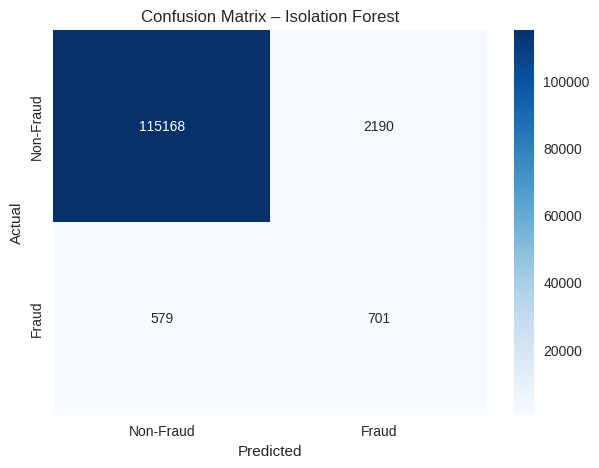


 Confusion Matrix Breakdown:
  True Negatives (TN): 115,168 - Correctly identified non-fraud
  False Positives (FP): 2,190 - Non-fraud incorrectly flagged as fraud
  False Negatives (FN): 579 - Fraud missed by the model ( CRITICAL!)
  True Positives (TP): 701 - Correctly detected fraud

 Key Performance Metrics (Imbalanced Dataset):
  Precision: 0.2425 - Of all fraud predictions, 24.25% were correct
  Recall (TPR): 0.5477 - Detected 54.77% of all actual fraud cases
  F1-Score: 0.3361 - Harmonic mean of precision and recall
  False Positive Rate: 0.0187 - 1.87% of legitimate transactions flagged
  ROC-AUC: 0.0322 - Overall discriminative ability
  PR-AUC: 0.0055 - Performance on imbalanced data ( MOST IMPORTANT)

 CRITICAL ANALYSIS:
   CONCERN: Moderate recall (54.77%)
    → Still missing 45.2% of fraud cases.
   CONCERN: Low precision (24.25%)
    → High false positive rate may reduce trust in the system.
   Imbalance between precision (24.25%) and recall (54.77%)
    → Consider thres

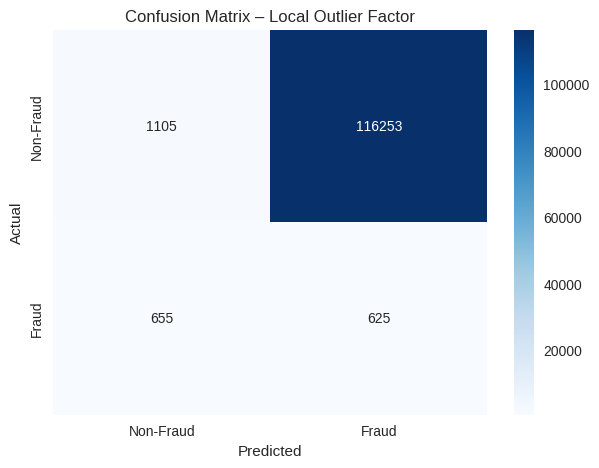


 Confusion Matrix Breakdown:
  True Negatives (TN): 1,105 - Correctly identified non-fraud
  False Positives (FP): 116,253 - Non-fraud incorrectly flagged as fraud
  False Negatives (FN): 655 - Fraud missed by the model ( CRITICAL!)
  True Positives (TP): 625 - Correctly detected fraud

 Key Performance Metrics (Imbalanced Dataset):
  Precision: 0.0053 - Of all fraud predictions, 0.53% were correct
  Recall (TPR): 0.4883 - Detected 48.83% of all actual fraud cases
  F1-Score: 0.0106 - Harmonic mean of precision and recall
  False Positive Rate: 0.9906 - 99.06% of legitimate transactions flagged
  ROC-AUC: 0.9701 - Overall discriminative ability
  PR-AUC: 0.3557 - Performance on imbalanced data ( MOST IMPORTANT)

 CRITICAL ANALYSIS:
    → This model is INADEQUATE for fraud detection.
    → Missed 655 out of 1280 fraud cases.
    → 99.5% of fraud alerts are false alarms!
    → This will overwhelm investigators with false positives.
   Imbalance between precision (0.53%) and recall (48.8

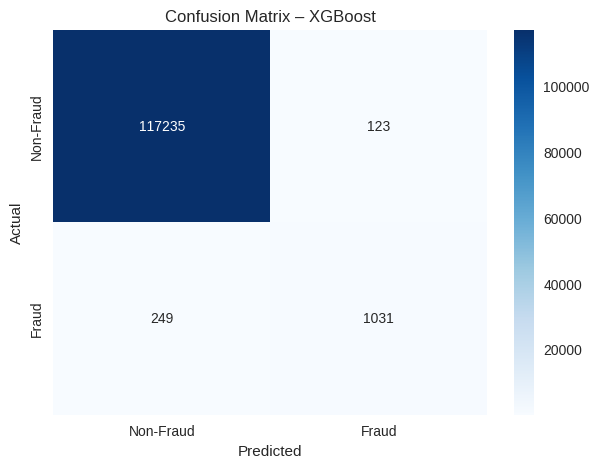


 Confusion Matrix Breakdown:
  True Negatives (TN): 117,235 - Correctly identified non-fraud
  False Positives (FP): 123 - Non-fraud incorrectly flagged as fraud
  False Negatives (FN): 249 - Fraud missed by the model ( CRITICAL!)
  True Positives (TP): 1,031 - Correctly detected fraud

 Key Performance Metrics (Imbalanced Dataset):
  Precision: 0.8934 - Of all fraud predictions, 89.34% were correct
  Recall (TPR): 0.8055 - Detected 80.55% of all actual fraud cases
  F1-Score: 0.8472 - Harmonic mean of precision and recall
  False Positive Rate: 0.0010 - 0.10% of legitimate transactions flagged
  ROC-AUC: 0.9986 - Overall discriminative ability
  PR-AUC: 0.9284 - Performance on imbalanced data ( MOST IMPORTANT)

 CRITICAL ANALYSIS:
  ✓ Good recall (80.55%) - Catching most fraud cases.
  ✓ Acceptable precision (89.34%)
  ✓ Good PR-AUC (0.9284) - Strong performance on imbalanced data

 BUSINESS IMPACT:
  - Fraud Detection Rate: 80.5% (1,031 out of 1,280)
  - Fraud Cases Missed: 249 ( Po

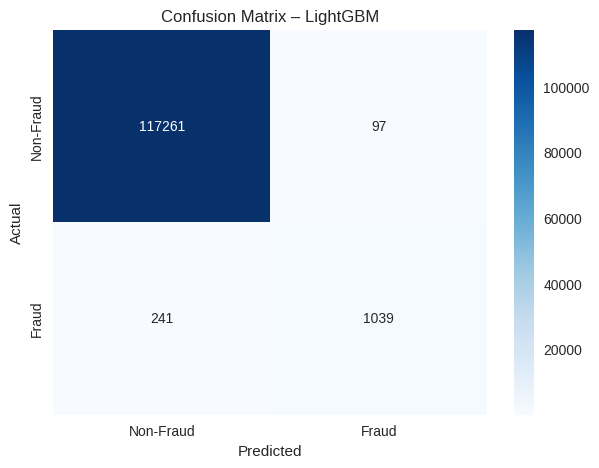


 Confusion Matrix Breakdown:
  True Negatives (TN): 117,261 - Correctly identified non-fraud
  False Positives (FP): 97 - Non-fraud incorrectly flagged as fraud
  False Negatives (FN): 241 - Fraud missed by the model ( CRITICAL!)
  True Positives (TP): 1,039 - Correctly detected fraud

 Key Performance Metrics (Imbalanced Dataset):
  Precision: 0.9146 - Of all fraud predictions, 91.46% were correct
  Recall (TPR): 0.8117 - Detected 81.17% of all actual fraud cases
  F1-Score: 0.8601 - Harmonic mean of precision and recall
  False Positive Rate: 0.0008 - 0.08% of legitimate transactions flagged
  ROC-AUC: 0.9991 - Overall discriminative ability
  PR-AUC: 0.9358 - Performance on imbalanced data ( MOST IMPORTANT)

 CRITICAL ANALYSIS:
  ✓ Good recall (81.17%) - Catching most fraud cases.
  ✓ Acceptable precision (91.46%)
  ✓ Good PR-AUC (0.9358) - Strong performance on imbalanced data

 BUSINESS IMPACT:
  - Fraud Detection Rate: 81.2% (1,039 out of 1,280)
  - Fraud Cases Missed: 241 ( Pot

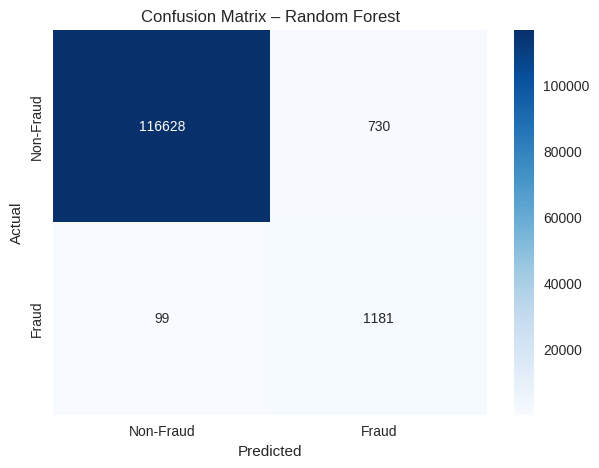


 Confusion Matrix Breakdown:
  True Negatives (TN): 116,628 - Correctly identified non-fraud
  False Positives (FP): 730 - Non-fraud incorrectly flagged as fraud
  False Negatives (FN): 99 - Fraud missed by the model ( CRITICAL!)
  True Positives (TP): 1,181 - Correctly detected fraud

 Key Performance Metrics (Imbalanced Dataset):
  Precision: 0.6180 - Of all fraud predictions, 61.80% were correct
  Recall (TPR): 0.9227 - Detected 92.27% of all actual fraud cases
  F1-Score: 0.7402 - Harmonic mean of precision and recall
  False Positive Rate: 0.0062 - 0.62% of legitimate transactions flagged
  ROC-AUC: 0.9981 - Overall discriminative ability
  PR-AUC: 0.8932 - Performance on imbalanced data ( MOST IMPORTANT)

 CRITICAL ANALYSIS:
  ✓ Good recall (92.27%) - Catching most fraud cases.
  ✓ Acceptable precision (61.80%)
   Imbalance between precision (61.80%) and recall (92.27%)
    → Consider threshold adjustment to balance metrics.
  ✓ Good PR-AUC (0.8932) - Strong performance on imbal

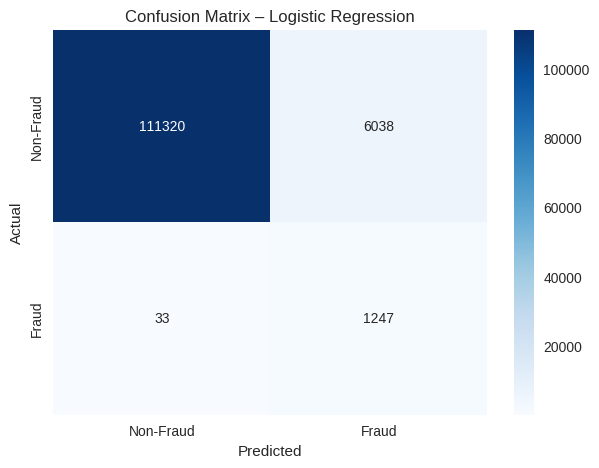


 Confusion Matrix Breakdown:
  True Negatives (TN): 111,320 - Correctly identified non-fraud
  False Positives (FP): 6,038 - Non-fraud incorrectly flagged as fraud
  False Negatives (FN): 33 - Fraud missed by the model ( CRITICAL!)
  True Positives (TP): 1,247 - Correctly detected fraud

 Key Performance Metrics (Imbalanced Dataset):
  Precision: 0.1712 - Of all fraud predictions, 17.12% were correct
  Recall (TPR): 0.9742 - Detected 97.42% of all actual fraud cases
  F1-Score: 0.2912 - Harmonic mean of precision and recall
  False Positive Rate: 0.0514 - 5.14% of legitimate transactions flagged
  ROC-AUC: 0.9947 - Overall discriminative ability
  PR-AUC: 0.8046 - Performance on imbalanced data ( MOST IMPORTANT)

 CRITICAL ANALYSIS:
  ✓ Good recall (97.42%) - Catching most fraud cases.
   CONCERN: Low precision (17.12%)
    → High false positive rate may reduce trust in the system.
   Imbalance between precision (17.12%) and recall (97.42%)
    → Consider threshold adjustment to balan

In [12]:
# ==============================================================
# 9. COMPREHENSIVE MODEL EVALUATION WITH CRITICAL ANALYSIS
# ==============================================================
print("\n DETAILED MODEL EVALUATION WITH CRITICAL ANALYSIS")
print("="*60)

def detailed_evaluation_with_analysis(y_true, y_pred, y_prob, name):
    print(f"\n{'='*60}")
    print(f" {name.upper()} - TEST SET EVALUATION ")
    print(f"{'='*60}")

    # Confusion matrix analysis
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate metrics (NO ACCURACY for imbalanced data)
    precision = tp/(tp+fp) if (tp+fp)>0 else 0
    recall = tp/(tp+fn) if (tp+fn)>0 else 0
    f1 = 2*tp/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0
    fpr = fp/(fp+tn) if (fp+tn)>0 else 0
    roc_auc = roc_auc_score(y_true, y_prob)
    pr_auc = average_precision_score(y_true, y_prob)

    # Confusion matrix visualization
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Fraud','Fraud'],
                yticklabels=['Non-Fraud','Fraud'])
    plt.title(f'Confusion Matrix – {name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Display confusion matrix components
    print(f"\n Confusion Matrix Breakdown:")
    print(f"  True Negatives (TN): {tn:,} - Correctly identified non-fraud")
    print(f"  False Positives (FP): {fp:,} - Non-fraud incorrectly flagged as fraud")
    print(f"  False Negatives (FN): {fn:,} - Fraud missed by the model ( CRITICAL!)")
    print(f"  True Positives (TP): {tp:,} - Correctly detected fraud")

    # Key metrics (excluding accuracy - inappropriate for imbalanced data)
    print(f"\n Key Performance Metrics (Imbalanced Dataset):")
    print(f"  Precision: {precision:.4f} - Of all fraud predictions, {precision*100:.2f}% were correct")
    print(f"  Recall (TPR): {recall:.4f} - Detected {recall*100:.2f}% of all actual fraud cases")
    print(f"  F1-Score: {f1:.4f} - Harmonic mean of precision and recall")
    print(f"  False Positive Rate: {fpr:.4f} - {fpr*100:.2f}% of legitimate transactions flagged")
    print(f"  ROC-AUC: {roc_auc:.4f} - Overall discriminative ability")
    print(f"  PR-AUC: {pr_auc:.4f} - Performance on imbalanced data ( MOST IMPORTANT)")

    # Critical Analysis
    print(f"\n CRITICAL ANALYSIS:")
    print(f"  {'='*55}")

    # Analyze recall (most critical for fraud detection)
    if recall < 0.5:
        print(f"   WARNING: Low recall ({recall:.2%}) - Missing most fraud cases!")
        print(f"    → This model is INADEQUATE for fraud detection.")
        print(f"    → Missed {fn} out of {tp+fn} fraud cases.")
    elif recall < 0.7:
        print(f"   CONCERN: Moderate recall ({recall:.2%})")
        print(f"    → Still missing {(1-recall)*100:.1f}% of fraud cases.")
    else:
        print(f"  ✓ Good recall ({recall:.2%}) - Catching most fraud cases.")

    # Analyze precision
    if precision < 0.1:
        print(f"   WARNING: Very low precision ({precision:.2%})")
        print(f"    → {(1-precision)*100:.1f}% of fraud alerts are false alarms!")
        print(f"    → This will overwhelm investigators with false positives.")
    elif precision < 0.3:
        print(f"   CONCERN: Low precision ({precision:.2%})")
        print(f"    → High false positive rate may reduce trust in the system.")
    else:
        print(f"  ✓ Acceptable precision ({precision:.2%})")

    # Analyze F1-Score balance
    if abs(precision - recall) > 0.3:
        print(f"   Imbalance between precision ({precision:.2%}) and recall ({recall:.2%})")
        print(f"    → Consider threshold adjustment to balance metrics.")

    # PR-AUC analysis (most important for imbalanced data)
    if pr_auc < 0.3:
        print(f"   Poor PR-AUC ({pr_auc:.4f}) - Model barely better than random for fraud class")
    elif pr_auc < 0.5:
        print(f"   Low PR-AUC ({pr_auc:.4f}) - Model performance is weak")
    elif pr_auc < 0.7:
        print(f"   Moderate PR-AUC ({pr_auc:.4f}) - Room for improvement")
    else:
        print(f"  ✓ Good PR-AUC ({pr_auc:.4f}) - Strong performance on imbalanced data")

    # Business impact
    total_fraud = tp + fn
    fraud_caught_pct = (tp / total_fraud * 100) if total_fraud > 0 else 0
    print(f"\n BUSINESS IMPACT:")
    print(f"  - Fraud Detection Rate: {fraud_caught_pct:.1f}% ({tp:,} out of {total_fraud:,})")
    print(f"  - Fraud Cases Missed: {fn:,} ( Potential financial loss!)")
    print(f"  - False Alarms: {fp:,} ( Investigation cost)")

    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'FPR': fpr,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn
    }
    return metrics

# Evaluate all models with detailed analysis
results_test = {}
for name in models.keys():
    results_test[name] = detailed_evaluation_with_analysis(y_test, predictions[name], prediction_probs[name], name)



 COMPARATIVE MODEL ANALYSIS


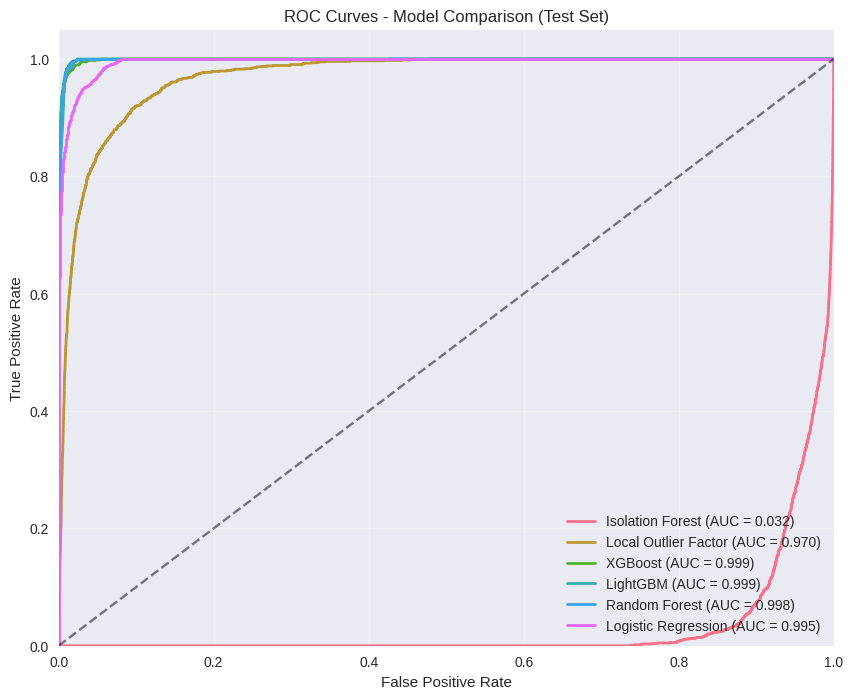

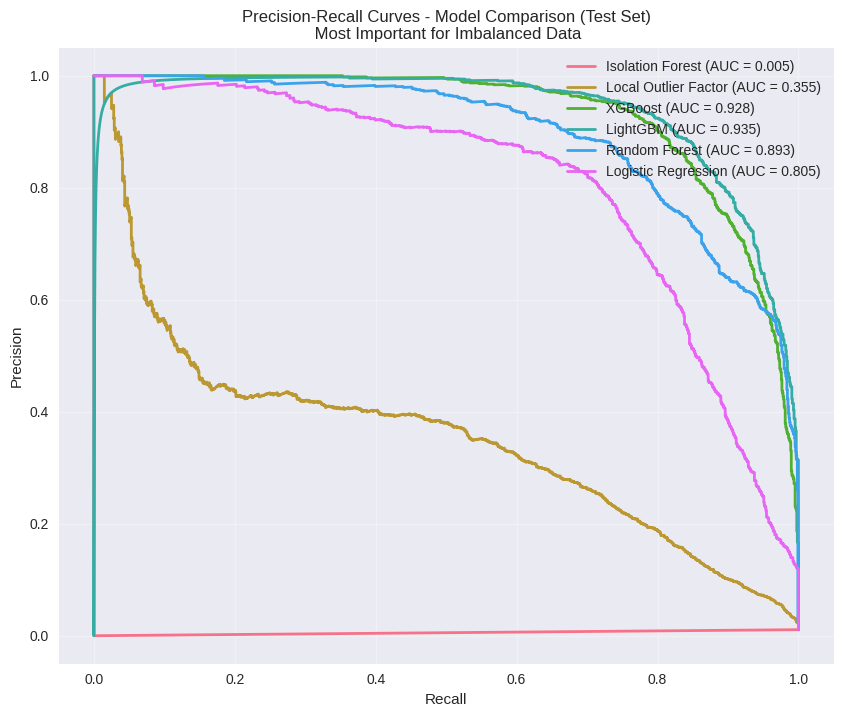

<Figure size 1200x800 with 0 Axes>

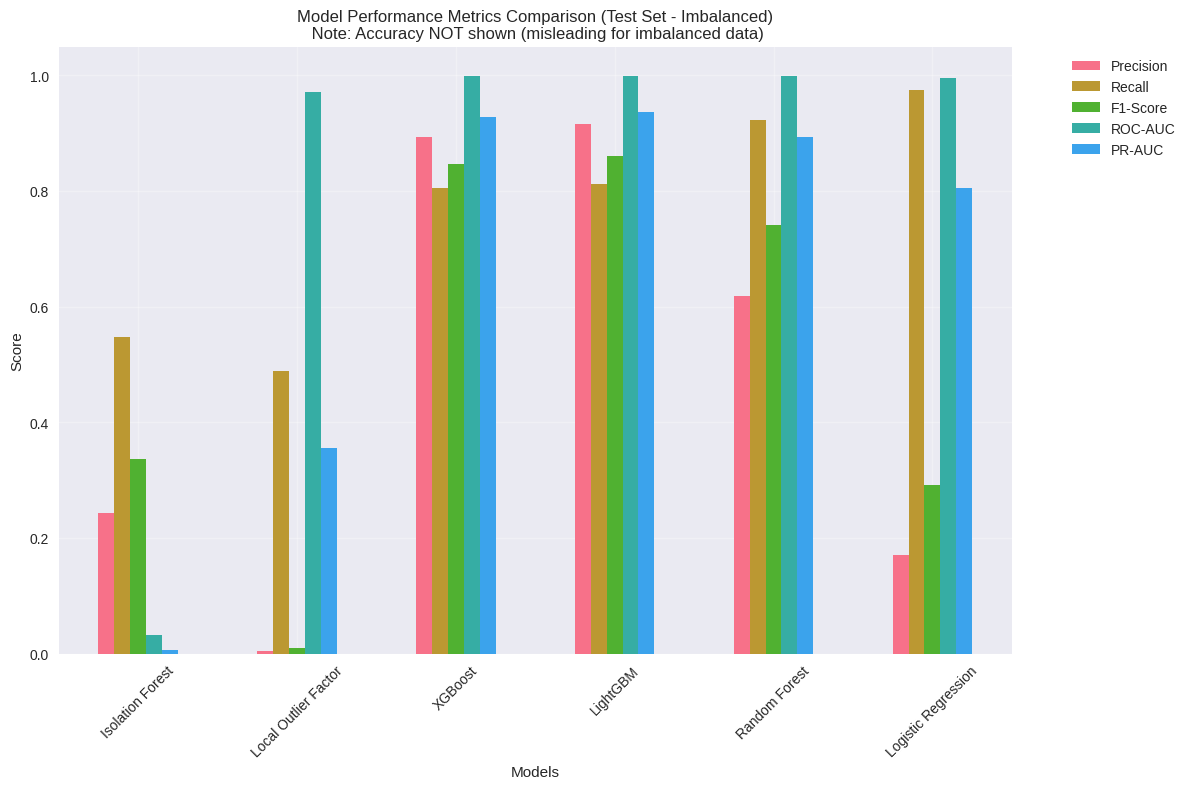


📊 PERFORMANCE SUMMARY TABLE:
                      Precision  Recall  F1-Score  ROC-AUC  PR-AUC
Isolation Forest         0.2425  0.5477    0.3361   0.0322  0.0055
Local Outlier Factor     0.0053  0.4883    0.0106   0.9701  0.3557
XGBoost                  0.8934  0.8055    0.8472   0.9986  0.9284
LightGBM                 0.9146  0.8117    0.8601   0.9991  0.9358
Random Forest            0.6180  0.9227    0.7402   0.9981  0.8932
Logistic Regression      0.1712  0.9742    0.2912   0.9947  0.8046


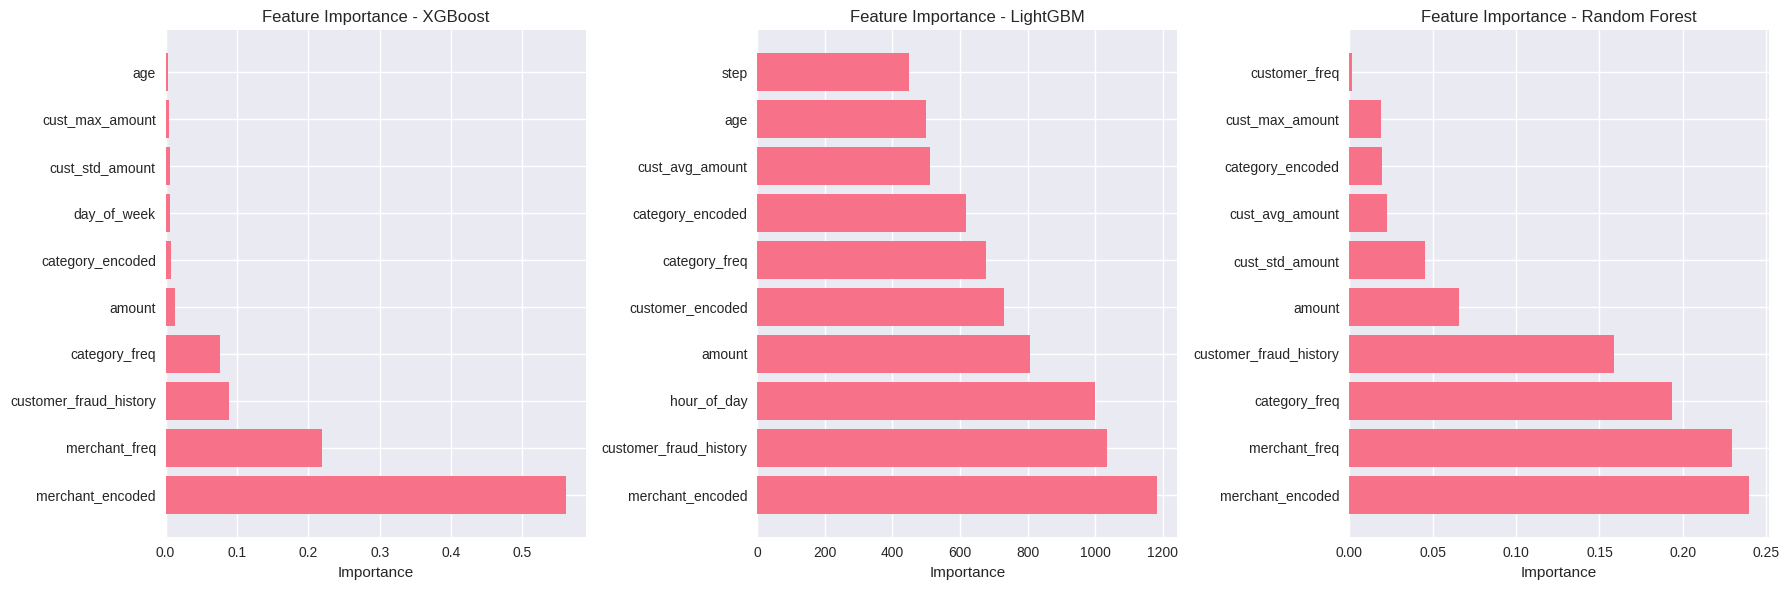

In [13]:
# ==============================================================
# 10. COMPARATIVE VISUALIZATIONS AND MODEL COMPARISON
# ==============================================================
print("\n" + "="*60)
print(" COMPARATIVE MODEL ANALYSIS")
print("="*60)

# 10.1 ROC Curve Comparison
plt.figure(figsize=(10, 8))
for name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, prediction_probs[name])
    roc_auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_val:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison (Test Set)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# 10.2 Precision-Recall Curve Comparison
plt.figure(figsize=(10, 8))
for name in models.keys():
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, prediction_probs[name])
    pr_auc_val = auc(recall_vals, precision_vals)
    plt.plot(recall_vals, precision_vals, label=f'{name} (AUC = {pr_auc_val:.3f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Model Comparison (Test Set)\n Most Important for Imbalanced Data')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()

# 10.3 Performance Metrics Comparison (excluding accuracy)
metrics_df_test = pd.DataFrame(results_test).T
metrics_display = metrics_df_test[['Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']]
plt.figure(figsize=(12, 8))
metrics_display.plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Metrics Comparison (Test Set - Imbalanced)\n Note: Accuracy NOT shown (misleading for imbalanced data)')
plt.ylabel('Score')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary table
print("\n📊 PERFORMANCE SUMMARY TABLE:")
print(metrics_display.round(4))

# 10.4 Feature Importance (for tree-based models)
tree_models = ['XGBoost', 'LightGBM', 'Random Forest']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for idx, model_name in enumerate(tree_models):
    if model_name in models:
        model = models[model_name]
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_names = feature_columns
            fi_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False).head(10)
            axes[idx].barh(fi_df['feature'], fi_df['importance'])
            axes[idx].set_title(f'Feature Importance - {model_name}')
            axes[idx].set_xlabel('Importance')
plt.tight_layout()
plt.show()

In [14]:
# ==============================================================
# 11. THRESHOLD OPTIMIZATION ANALYSIS
# ==============================================================
print("\n" + "="*60)
print("  THRESHOLD OPTIMIZATION ANALYSIS")
print("="*60)

def find_optimal_threshold(y_true, y_prob):
    """Find optimal threshold using Youden's J statistic"""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold, fpr[optimal_idx], tpr[optimal_idx]

# Select best model based on PR-AUC (more appropriate for imbalanced data)
best_model_name = None
best_model_probs = None
best_pr_auc = -1

for model_name, y_prob in prediction_probs.items():
    pr_auc_val = average_precision_score(y_test, y_prob)
    if pr_auc_val > best_pr_auc:
        best_pr_auc = pr_auc_val
        best_model_name = model_name
        best_model_probs = y_prob

print(f"\n Best model selected: {best_model_name} (PR-AUC: {best_pr_auc:.4f})")
print("Note: Model selected based on PR-AUC (best metric for imbalanced data)\n")

# Apply threshold optimization
optimal_threshold, optimal_fpr, optimal_tpr = find_optimal_threshold(y_test, best_model_probs)
print(f" Optimal threshold: {optimal_threshold:.4f}")
print(f"At this threshold - FPR: {optimal_fpr:.4f}, TPR (Recall): {optimal_tpr:.4f}")

# Apply optimal threshold
y_pred_optimal = (best_model_probs >= optimal_threshold).astype(int)
print(f"\n {best_model_name} with Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal, digits=4, target_names=['Non-Fraud', 'Fraud']))

# Show improvement from default threshold
print("\n📈 Comparison: Default (0.5) vs Optimal Threshold:")
print(f"Threshold: 0.5000 → {optimal_threshold:.4f}")
print(f"Precision: {precision_score(y_test, predictions[best_model_name]):.4f} → {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall:    {recall_score(y_test, predictions[best_model_name]):.4f} → {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1-Score:  {f1_score(y_test, predictions[best_model_name]):.4f} → {f1_score(y_test, y_pred_optimal):.4f}")



  THRESHOLD OPTIMIZATION ANALYSIS

 Best model selected: LightGBM (PR-AUC: 0.9358)
Note: Model selected based on PR-AUC (best metric for imbalanced data)

 Optimal threshold: 0.0015
At this threshold - FPR: 0.0172, TPR (Recall): 0.9953

 LightGBM with Optimal Threshold:
              precision    recall  f1-score   support

   Non-Fraud     0.9999    0.9828    0.9913    117358
       Fraud     0.3871    0.9953    0.5574      1280

    accuracy                         0.9829    118638
   macro avg     0.6935    0.9891    0.7744    118638
weighted avg     0.9933    0.9829    0.9866    118638


📈 Comparison: Default (0.5) vs Optimal Threshold:
Threshold: 0.5000 → 0.0015
Precision: 0.9146 → 0.3871
Recall:    0.8117 → 0.9953
F1-Score:  0.8601 → 0.5574


In [16]:
# ==============================================================
# 12. FINAL SUMMARY, CRITICAL ANALYSIS, AND RECOMMENDATIONS
# ==============================================================
print("\n" + "="*60)
print("  FINAL SUMMARY AND CRITICAL ANALYSIS")
print("="*60)

# Model ranking by PR-AUC (most appropriate for imbalanced data)
summary_df = pd.DataFrame(results_test).T
summary_df = summary_df.sort_values('PR-AUC', ascending=False)

print("\n MODEL RANKING (by PR-AUC - Best for Imbalanced Data):")
print(summary_df[['PR-AUC', 'ROC-AUC', 'F1-Score', 'Precision', 'Recall']].round(4))

# Identify best and worst models
best_model_ranked = summary_df.index[0]
worst_model_ranked = summary_df.index[-1]
best_metrics = summary_df.iloc[0]
worst_metrics = summary_df.iloc[-1]

print(f"\n" + "="*60)
print("  CRITICAL ANALYSIS OF RESULTS")
print("="*60)

print(f" BEST PERFORMING MODEL: {best_model_ranked}")
print(f"   • PR-AUC: {best_metrics['PR-AUC']:.4f}")
print(f"   • Recall: {best_metrics['Recall']:.4f} (catches {best_metrics['Recall']*100:.1f}% of fraud)")
print(f"   • Precision: {best_metrics['Precision']:.4f} ({best_metrics['Precision']*100:.1f}% of alerts are real fraud)")
print(f"   • F1-Score: {best_metrics['F1-Score']:.4f}")

print(f"\n WORST PERFORMING MODEL: {worst_model_ranked}")
print(f"   • PR-AUC: {worst_metrics['PR-AUC']:.4f}")
print(f"   • Recall: {worst_metrics['Recall']:.4f} (only catches {worst_metrics['Recall']*100:.1f}% of fraud)")
print(f"   • Precision: {worst_metrics['Precision']:.4f}")
print(f"   • Why it performs poorly: ", end="")
if worst_metrics['Recall'] < 0.3:
    print(f"Missing {(1-worst_metrics['Recall'])*100:.1f}% of fraud cases - UNACCEPTABLE ")
elif worst_metrics['Precision'] < 0.1:
    print(f"Too many false alarms ({(1-worst_metrics['Precision'])*100:.1f}% false positive rate) ")
else:
    print("Poor balance between precision and recall ")

# Overall assessment
print(f"\n OVERALL ASSESSMENT:")
if best_metrics['PR-AUC'] < 0.5:
    print("    WARNING: Even the best model has weak performance (PR-AUC < 0.5)")
    print("   → Recommendations: Collect more features, try deep learning, or ensemble methods")
elif best_metrics['PR-AUC'] < 0.7:
    print("    Models show moderate performance - room for improvement")
    print("   → Consider: Feature engineering, different sampling strategies, or ensemble")
else:
    print("    Best model shows strong performance for fraud detection")

if best_metrics['Recall'] < 0.6:
    print(f"    CONCERN: Missing {(1-best_metrics['Recall'])*100:.1f}% of fraud cases")
    print("   → This could result in significant financial losses ")

if best_metrics['Precision'] < 0.2:
    print(f"    CONCERN: High false alarm rate ({(1-best_metrics['Precision'])*100:.1f}% false positives)")
    print("   → This will overwhelm fraud investigation teams ")

# Why unsupervised models might fail
print(f"\n UNSUPERVISED vs SUPERVISED MODELS:")
iso_metrics = results_test.get('Isolation Forest', {})
lof_metrics = results_test.get('Local Outlier Factor', {})
if iso_metrics and iso_metrics.get('PR-AUC', 0) < 0.3:
    print("   • Isolation Forest performs poorly because:")
    print("     → Fraud patterns may not be simple outliers")
    print("     → Fraudsters may mimic legitimate behavior")
    print("     → Unsupervised methods lack labeled fraud examples for learning")

if lof_metrics and lof_metrics.get('Precision', 0) < 0.1:
    print("   • Local Outlier Factor has very low precision:")
    print("     → Flags too many normal transactions as anomalies")
    print("     → Not practical for real-world deployment")

# Business impact and recommendations
total_fraud = int(best_metrics['TP'] + best_metrics['FN'])
detected = int(best_metrics['TP'])
missed = int(best_metrics['FN'])
false_alarms = int(best_metrics['FP'])

print(f"\n" + "="*60)
print("  BUSINESS IMPACT & RECOMMENDATIONS")
print("="*60)

print(f"\n DEPLOYMENT RECOMMENDATION:")
print(f" → Use {best_model_ranked} with optimized threshold {optimal_threshold:.4f}")

print(f"\n EXPECTED PERFORMANCE IN PRODUCTION:")
print(f" • Fraud cases in test: {total_fraud:,}")
print(f" • Fraud detected: {detected:,} ({detected/total_fraud*100:.1f}%)")
print(f" • Fraud missed: {missed:,} ({missed/total_fraud*100:.1f}%)  FINANCIAL RISK")
print(f" • False alarms: {false_alarms:,} (investigation cost)")



  FINAL SUMMARY AND CRITICAL ANALYSIS

 MODEL RANKING (by PR-AUC - Best for Imbalanced Data):
                      PR-AUC  ROC-AUC  F1-Score  Precision  Recall
LightGBM              0.9358   0.9991    0.8601     0.9146  0.8117
XGBoost               0.9284   0.9986    0.8472     0.8934  0.8055
Random Forest         0.8932   0.9981    0.7402     0.6180  0.9227
Logistic Regression   0.8046   0.9947    0.2912     0.1712  0.9742
Local Outlier Factor  0.3557   0.9701    0.0106     0.0053  0.4883
Isolation Forest      0.0055   0.0322    0.3361     0.2425  0.5477

  CRITICAL ANALYSIS OF RESULTS
 BEST PERFORMING MODEL: LightGBM
   • PR-AUC: 0.9358
   • Recall: 0.8117 (catches 81.2% of fraud)
   • Precision: 0.9146 (91.5% of alerts are real fraud)
   • F1-Score: 0.8601

 WORST PERFORMING MODEL: Isolation Forest
   • PR-AUC: 0.0055
   • Recall: 0.5477 (only catches 54.8% of fraud)
   • Precision: 0.2425
   • Why it performs poorly: Poor balance between precision and recall 

 OVERALL ASSESSMENT